## Libraries to import ##

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

## Function's definitions used in exercises 1 and 2

As soon as the process for collecting data from IS-Academia is almost the same for bachelor and master students, we define functions that we serve for the two exercises.

First of all, here is the function that collects the raw data from the server. It returns the beautifulsoup HTML file with all the students registered in the year and the semester given in parameters.

In [5]:
def getRawData(year, sem):
    payload = {'ww_x_GPS': '-1',
               'ww_i_reportModel': 133685247,
               'ww_i_reportModelXsl': 133685270,
               'ww_x_UNITE_ACAD': 249847,
               'ww_x_PERIODE_ACAD': year,
               'ww_x_PERIODE_PEDAGO': sem,
               'ww_x_HIVERETE': 'null'
              }

    data = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params=payload)
    return BeautifulSoup(data.text, 'html.parser')

The next function uses raw data from the previous function and structures them to obtain a list of students. Each student is a dictionary with the following properties: civility, name, sciper, academic year, semester, minor and the specialization.

In [6]:
def getStructuredData(year, sem):
    raw_data = getRawData(year, sem)
    students = []
    
    for tr in raw_data.html.body.hr.table.findAll('tr'):
        tds = tr.findAll('td')
        if (len(tds) > 0):
            student = {
                'civility': tds[0].text,
                'name': tds[1].text,
                'sciper': tds[10].text,
                'academic year': all_years.get(year),
                'semester': all_semesters.get(sem),
                'minor': tds[6].text,
                'specialization': tds[4].text
                }
            students.append(student)
    return students

Now, to make it easy, we create a function "getDataFrame" that returns a pandas dataframe with all the students registered for the years in the list "years" and for the semesters in the list "semesters", both passed in parameters.

In [7]:
def getDataFrame(years, semesters):
    results = []
    
    for year in years:
        for sem in semesters:
            results.extend(getStructuredData(year, sem))
    
    return pd.DataFrame(results)

Finally we create 2 dictionaries that associate the request's code of each kind of semester to their nomination and the same for academic years.
Moreover, to create a kind of bijection between the name and the code, we create a function getCode.

In [8]:
all_semesters = {
    249108: 'bachelor1',
    942175: 'bachelor6',
    2230106: 'master1',
    942192: 'master2',
    2230128: 'master3',
    249127: 'project_autumn',
    3781783: 'project_spring'
}

all_years = {
    978181: '2007-2008',
    978187: '2008-2009',
    978195: '2009-2010',
    39486325: '2010-2011',
    123455150: '2011-2012',
    123456101: '2012-2013',
    213637754: '2013-2014',
    213637922: '2014-2015',
    213638028: '2015-2016',
    355925344: '2016-2017'
}

def getCode(dictionary, value):
    for code, name in dictionary.items():
        if name == value:
            return code

# Exercise 1

In [9]:
# ==================================================================================
# /!\ Quite slow to get the data, so try to not execute this cell too many times /!\
# ==================================================================================

student_bac1 = getDataFrame(all_years, [getCode(all_semesters, 'bachelor1')])
student_bac6 = getDataFrame(all_years, [getCode(all_semesters, 'bachelor6')])

In [10]:
student_bac1.sort_values('academic year', inplace=True)
student_bac6.sort_values('academic year', inplace=True)

student_bac1.drop_duplicates(subset=['sciper'], keep='first', inplace=True)
student_bac6.drop_duplicates(subset=['sciper'], keep='last', inplace=True)

student_bac1.set_index(['sciper'], inplace=True)
student_bac6.set_index(['sciper'], inplace=True)

student_bac1.drop('minor', axis=1, inplace=True)
student_bac1.drop('specialization', axis=1, inplace=True)
student_bac1.drop('semester', axis=1, inplace=True)

student_bac6 = student_bac6.loc[:, ['academic year']]

student_bac1.columns = ['arrival year', 'civility', 'name']
student_bac6.columns = ['graduation year']

students = pd.concat([student_bac1, student_bac6], axis=1, join='inner')

In [11]:
students = students[['civility', 'name', 'arrival year', 'graduation year']]

students['duration'] = [int(dep.split("-")[1]) - int(arr.split("-")[0])
                        for arr, dep in students[['arrival year', 'graduation year']].values]

students['duration'] *= 10

students.head()

,civility,name,arrival year,graduation year,duration
sciper,,,,,
169569,Monsieur,Arévalo Christian,2007-2008,2009-2010,30
180570,Monsieur,Habfast Paul,2007-2008,2009-2010,30
175190,Monsieur,Hanser Valérian,2007-2008,2009-2010,30
181298,Monsieur,Lütolf Lukas,2007-2008,2009-2010,30
181248,Monsieur,Helfer Etienne,2007-2008,2009-2010,30


In [12]:
students.sort_values('civility', ascending=1)
students['civility'].value_counts(normalize=True, sort=True, ascending=True)

Madame      0.073048
Monsieur    0.926952
Name: civility, dtype: float64

As we can notice (even in master) there is a huge minority of women in computer science 

civility
Madame      [[Axes(0.125,0.125;0.775x0.775)]]
Monsieur    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

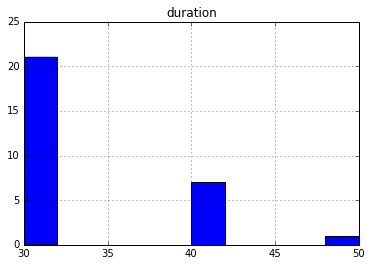

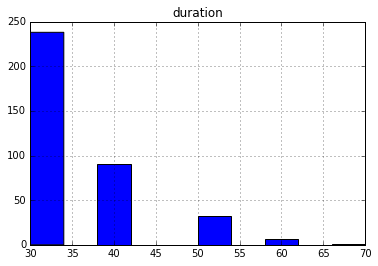

In [13]:
students.groupby(['civility']).hist()

In [14]:
students.groupby(['civility'])[['duration']].mean().round(3)

,duration
civility,
Madame,33.103
Monsieur,34.810


In [15]:
students['sex'] = (students['civility'] == 'Monsieur').astype(int)

In [16]:
import scipy.stats as sts

obs = np.array([students['sex'], students['duration']])
g, p, dof, expctd = scipy.stats.chi2_contingency(obs)
print('p-value is  : ' , p)

NameError: name 'scipy' is not defined

As expected, given the high p-value, the test result does not detect a significant relationship between the variables.

In [17]:
rvs1 = students[students['civility']== 'Madame']['duration']
rvs2 = students[students['civility']== 'Monsieur']['duration']
sts.ks_2samp(rvs1, rvs2)

Ks_2sampResult(statistic=0.077398800599700168, pvalue=0.99572515917079174)

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.




# Exercise 2

First step is to get all the student that made a master semester 1, 2 and 3. We store these students in 3 different dataframes student_ma1, student_ma2 and student_ma3.

We do the same for the 2 master project (autumn and spring).

In [18]:
# ==================================================================================
# /!\ Quite slow to get the data, so try to not execute this cell too many times /!\
# ==================================================================================

student_ma1 = getDataFrame(all_years, [getCode(all_semesters, 'master1')])
student_ma2 = getDataFrame(all_years, [getCode(all_semesters, 'master2')])
student_ma3 = getDataFrame(all_years, [getCode(all_semesters, 'master3')])
student_maP_aut = getDataFrame(all_years, [getCode(all_semesters, 'project_autumn')])
student_maP_spr = getDataFrame(all_years, [getCode(all_semesters, 'project_spring')])

Let's start to manage data:
In order to have a better view of the data, we sort them by the academic year in our 5 dataframes.

In [19]:
student_ma1.sort_values('academic year', inplace=True)
student_ma2.sort_values('academic year', inplace=True)
student_ma3.sort_values('academic year', inplace=True)
student_maP_aut.sort_values('academic year', inplace=True)
student_maP_spr.sort_values('academic year', inplace=True)

Sometimes a student can do the "master semester 1" more than once, if he fails its year and restart it the year after. In this case, we only want to keep the first "master semester 1" that he did here. Indeed, we want to compute the total time he spent at the EPFL.
But for the two other dataframes, we want the opposite: keeping the last semester the student did here.

In [20]:
student_ma1.drop_duplicates(subset=['sciper'], keep='first', inplace=True)
student_ma2.drop_duplicates(subset=['sciper'], keep='last', inplace=True)
student_ma3.drop_duplicates(subset=['sciper'], keep='last', inplace=True)

The sciper is already unique for the two dataframes with students doing their master project.

In [21]:
print(student_maP_aut.sciper.is_unique)
print(student_maP_spr.sciper.is_unique)

True
True


Now we can use the sciper number as index because it should be unique for each dataframe. It is going to be useful to make the concatenation.

In [22]:
student_ma1.set_index('sciper', inplace=True)
student_ma2.set_index('sciper', inplace=True)
student_ma3.set_index('sciper', inplace=True)
student_maP_aut.set_index('sciper', inplace=True)
student_maP_spr.set_index('sciper', inplace=True)

The goal being to find the duration spent at the EPFL for each student, we have to clean a little bit the dataframes.

We make the assumption that if a student chose a minor or a specialization in the semester 1, this minor/specialization will still be present for him in the semester 2. So we can drop those 2 columns in the student_ma1 dataframe.
Likewise, we can drop the columns name and civility in the student_ma2.

For the 3 other dataframes, we only need to keep the year associated to the sciper number. So we drop the other columns.

In [23]:
student_ma1.drop('minor', axis=1, inplace=True)
student_ma1.drop('specialization', axis=1, inplace=True)
student_ma1.drop('semester', axis=1, inplace=True)

student_ma2.drop('civility', axis=1, inplace=True)
student_ma2.drop('name', axis=1, inplace=True)
student_ma2.drop('semester', axis=1, inplace=True)

student_ma3 = student_ma3.loc[:, ['academic year']]
student_maP_aut = student_maP_aut.loc[:, ['academic year']]
student_maP_spr = student_maP_spr.loc[:, ['academic year']]

To display it properly, let's rename the columns before concatenating the dataframes and reordering their columns.

In [24]:
student_ma1.columns = ['semester 1', 'civility', 'name']
student_ma2.columns = ['semester 2', 'minor', 'specialization']
student_ma3.columns = ['semester 3']
student_maP_aut.columns = ['project aut']
student_maP_spr.columns = ['project spr']

students = pd.concat([student_ma1, student_ma2], axis=1, join="inner")
students = pd.concat([students,student_ma3, student_maP_aut, student_maP_spr] , axis = 1)

# Reordering the columns
students = students[['civility', 'name', 'semester 1', 'semester 2','semester 3','project aut','project spr', 'minor', 'specialization']]

students.dropna(subset = ['civility'] , inplace = True)
students.fillna(value='',inplace = True)

students.head(100)

,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization
146330,Monsieur,Cardinaux Damien,2007-2008,2007-2008,2008-2009,,,,
146742,Monsieur,Marx Clément,2008-2009,2009-2010,2012-2013,2010-2011,2010-2011,,"Signals, Images and Interfaces"
146929,Monsieur,Junod Antoine,2007-2008,2007-2008,,,,,
147008,Monsieur,Good Xavier,2011-2012,2012-2013,2012-2013,,,,
152232,Monsieur,Anagnostaras David,2007-2008,2007-2008,2008-2009,,,"Mineur en Management, technologie et entrepren...",
153066,Monsieur,Aeberhard François-Xavier,2007-2008,2009-2010,2009-2010,,,,Internet computing
153746,Monsieur,Cassina Ilya,2007-2008,2007-2008,,,,,
153762,Monsieur,Conus Johann,2008-2009,2009-2010,2009-2010,,,,
154080,Monsieur,Fomene Tierry Alain,2007-2008,2008-2009,2009-2010,,,,Internet computing
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing


In order to compute the duration that each student spend at the EPFL we worked with those steps :
- First we set the duration depending on how many years there is between the first and second semester. Some students did their second semester before the first one.
- If the student did a semester 3 we add 6 months (0.5 year)
- Otherwise, if the student do not have a semester 3 but have done a specialization or a minor (that should not happen !), we also add 6 months
- Then, for each project master the student did (some student have both in autumn and spring), we add 6 months.
- Last possibility is that the student did not mentioned his project master. In this case we make the assumption that he did one once as soon as the master thesis is mandatory at the EPFL. So we also add 6 months.

In [25]:
def getDuration(sem1, sem2):
    if int(sem2[0]) >= int(sem1[0]):
        return int(sem2[1]) - int(sem1[0])
    else: 
        return int(sem1[0]) - int(sem2[0])

students['duration'] = [getDuration(sem1.split("-"), sem2.split('-'))
                        for sem1, sem2 in students[['semester 1', 'semester 2']].values]

for i,row in students.iterrows() : 
    if (row['semester 3'] != '') :
        students.loc[i,'duration'] += 0.5
    elif ((row['minor'] != '' or row['specialization'] != '')) : 
        students.loc[i,'duration'] += 0.5
    if (row['project aut'] != '') :
        students.loc[i,'duration'] += 0.5     
    if (row['project spr'] != '') :
        students.loc[i,'duration'] += 0.5
    if (row['project spr'] == '' and row['project aut'] == '' ) :
        students.loc[i,'duration'] += 0.5

students

,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization,duration
146330,Monsieur,Cardinaux Damien,2007-2008,2007-2008,2008-2009,,,,,2.0
146742,Monsieur,Marx Clément,2008-2009,2009-2010,2012-2013,2010-2011,2010-2011,,"Signals, Images and Interfaces",3.5
146929,Monsieur,Junod Antoine,2007-2008,2007-2008,,,,,,1.5
147008,Monsieur,Good Xavier,2011-2012,2012-2013,2012-2013,,,,,3.0
152232,Monsieur,Anagnostaras David,2007-2008,2007-2008,2008-2009,,,"Mineur en Management, technologie et entrepren...",,2.0
153066,Monsieur,Aeberhard François-Xavier,2007-2008,2009-2010,2009-2010,,,,Internet computing,4.0
153746,Monsieur,Cassina Ilya,2007-2008,2007-2008,,,,,,1.5
153762,Monsieur,Conus Johann,2008-2009,2009-2010,2009-2010,,,,,3.0
154080,Monsieur,Fomene Tierry Alain,2007-2008,2008-2009,2009-2010,,,,Internet computing,3.0
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing,3.0


Here is a plot to visualize the proportions of students grouped by the duration of their master.

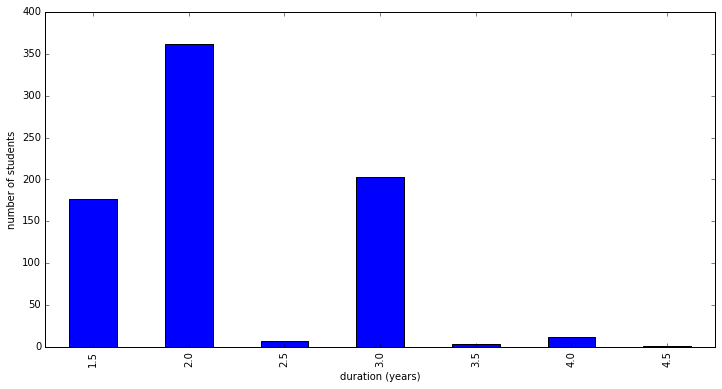

In [26]:
plt.figure(figsize=(12,6))

ax = students.groupby(['duration']).count().name.plot(kind='bar')
ax.set(xlabel='duration (years)', ylabel='number of students')

In [27]:
overall_avg_duration = students['duration'].mean()
print('The overall average duration is:', round(overall_avg_duration, 3))

The overall average duration is: 2.196


In [28]:
students_with_specialization = students[students['specialization'] != ''].sort_values('specialization')
students_with_specialization.head(180)

,civility,name,semester 1,semester 2,semester 3,project aut,project spr,minor,specialization,duration
154573,Madame,Benabdallah Zeineb,2007-2008,2008-2009,2009-2010,,2009-2010,,Biocomputing,3.0
169734,Monsieur,Koller Yannick,2007-2008,2008-2009,2009-2010,,,,Biocomputing,3.0
224627,Monsieur,Bloch Aurélien François Gilbert,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
178271,Monsieur,Boéchat Marc-Alexandre,2010-2011,2010-2011,2011-2012,,,,Computer Engineering - SP,2.0
223825,Monsieur,Vassor Martin Thomas,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
178283,Monsieur,Brunet Yorick,2009-2010,2009-2010,2010-2011,,,,Computer Engineering - SP,2.0
217301,Madame,Pignat Eliéva Arlette,2014-2015,2015-2016,2015-2016,2016-2017,,,Computer Engineering - SP,3.0
216690,Monsieur,Roulin Andy,2014-2015,2015-2016,2016-2017,,,,Computer Engineering - SP,3.0
244206,Monsieur,Doy Damien,2015-2016,2015-2016,2016-2017,,,,Computer Engineering - SP,2.0
214225,Monsieur,Depraz Florian Vincent,2014-2015,2015-2016,2016-2017,,,,Computer Engineering - SP,3.0


Now we can compare visually how many years students stayed at the EPFL, depending on their specialization.

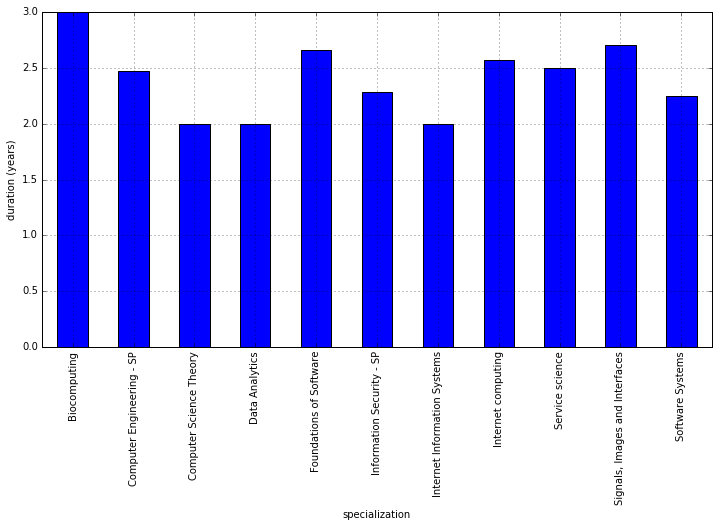

In [29]:
means_specialization = students_with_specialization.groupby(['specialization'])[['duration']]

fig, ax = plt.subplots(figsize=(12,6))
means_specialization.mean().plot(ax=ax, kind='bar', legend=False, grid=True).set_ylabel('duration (years)')

In [30]:
from scipy import stats
rvs1 =means_specialization.duration
rvs2 = np.array(means_specialization).mean()*np.ones(11)
stats.ks_2samp(rvs1, rvs2)

Exception: Column(s) ['duration'] already selected

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

Biocomputing is harder :D

# Bonus

We start by figuring out how many records correspond to male and female Master students.

In [31]:
students.groupby(['civility'])[['name']].count()

,name
civility,
Madame,101
Monsieur,663


Male students clearly outnumber female students.

In [32]:
students.groupby(['civility'])[['duration']].mean()

,duration
civility,
Madame,2.217822
Monsieur,2.192308


In average, female students take a little longer than male students to conclude their Master studies at EPFL.

civility
Madame      [[Axes(0.125,0.125;0.775x0.775)]]
Monsieur    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

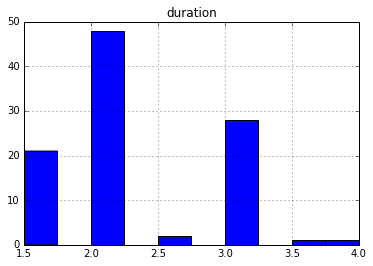

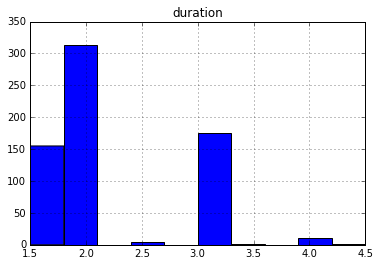

In [33]:
# TODO: change this to bar plots
students.groupby(['civility']).hist()

Similar to what was done to compute the duration of the stay of each student at EPFL, we compare the entries from the first and the second semester to get the year when each student started its Master studies.

In [34]:
def get_first_year(sem1, sem2):
    if int(sem2[0]) >= int(sem1[0]):
        return int(sem1[0])
    else: 
        return int(sem2[0])

students['first year'] = [get_first_year(sem1.split("-"), sem2.split('-'))
                          for sem1, sem2 in students[['semester 1', 'semester 2']].values]

We now compute the average stay of Master students at EPFL according to the year when they started their studies.

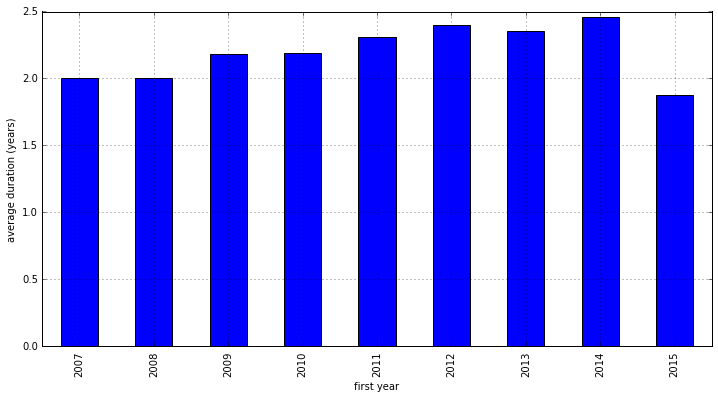

In [35]:
grouped_by_year = students.groupby(['first year'])

fig, ax = plt.subplots(figsize=(12,6))
grouped_by_year.mean().plot(ax=ax, kind='bar', grid=True, legend=False).set_ylabel('average duration (years)')

Students who started their Master in 2014 took, in average, more time to complete it.

We also want to identify changes over time. To do so, we start by plotting the duration of Master studies of each student according to the year when they started their studies.

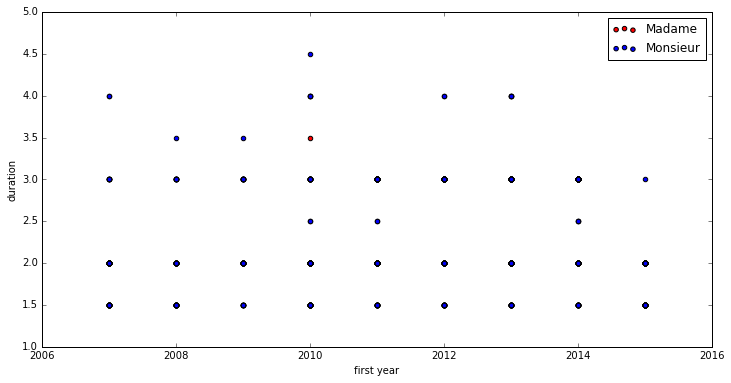

In [36]:
fig, ax = plt.subplots(figsize=(12,6))

colors = {'Madame':'red', 'Monsieur':'blue'}
grouped_by_gender = students.groupby(['civility'])

for key, gender in grouped_by_gender:
    gender.plot(ax=ax, kind='scatter', x='first year', y='duration', label=key, color=colors[key])

plt.show()

Let's now take a look at the average stay according to gender and first year of Master studies.

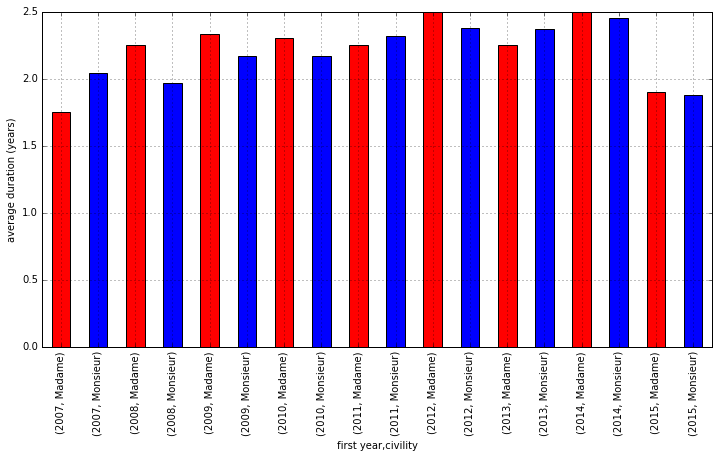

In [37]:
grouped_by_gender_year = students.groupby(['first year', 'civility'])

fig, ax = plt.subplots(figsize=(12,6))
grouped_by_gender_year.mean().plot(ax=ax, kind='bar', color=['r','b']*9, grid=True, legend=False).set_ylabel('average duration (years)')

The year of 2008 seems to be the one when a larger difference in average graduation time between female and male students was recorded. This difference seems to be getting smaller.

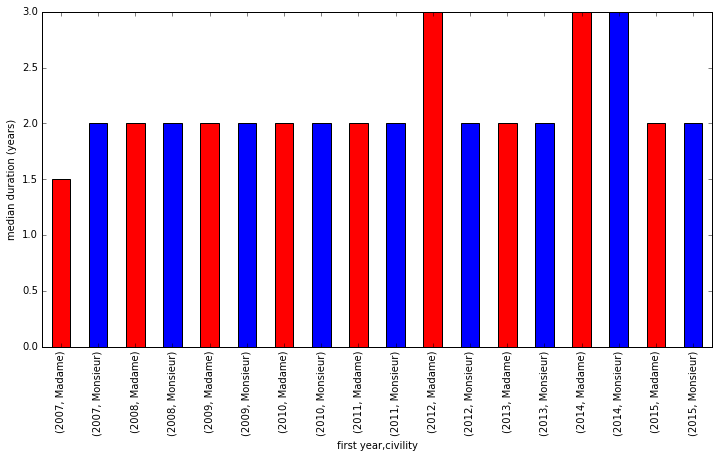

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
grouped_by_gender_year.median().plot(ax=ax, kind='bar', color=['r','b']*9, legend=False).set_ylabel('median duration (years)')

If we now take a look at the median duration throughout the years, we note that 2012 was the year when the discrepancy between genders was the biggest. Apart from this year and 2007, the median is equal for both genders.

We can conclude that students who started their Master in 2012 or 2014 where the ones taking the longest to graduate. One must note that students who started their studies in 2015 might not have finished their Master yet and that can affect the results here displayed.